In [ ]:
import pandas as pd
import numpy as np
import math

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#from sklearn.mixture import GMM

from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot as plt

In [43]:
dataset = pd.read_csv("merged_training_dataset.csv")

In [44]:
dataset = dataset[dataset['order_status'] == 'delivered']
len(dataset)

115728

In [45]:
dataset.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'quantity', 'product_id', 'seller_id', 'shipping_limit_date',
       'product_price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'seller_lat', 'sellet_lng', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'customer_lat', 'customer_lng'],
      dtype='object')

In [46]:
dataset.dropna(subset=[ 'order_delivered_customer_date', 'order_delivered_carrier_date', 'order_approved_at', 'seller_lat', 'customer_lat','product_category'],inplace=True)
len(dataset)

113487

In [47]:
dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,quantity,product_id,...,seller_city,seller_state,seller_lat,sellet_lng,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13T08:59:02Z,2017-09-13T09:45:35Z,2017-09-19T18:34:16Z,2017-09-20T23:43:48Z,2017-09-29T00:00:00Z,1,4244733e06e7ecb4970a6e2683c13e61,...,volta redonda,SP,-22.498183,-44.123614,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26T10:53:06Z,2017-04-26T11:05:13Z,2017-05-04T14:35:00Z,2017-05-12T16:04:24Z,2017-05-15T00:00:00Z,1,e5f2d52b802189ee658865ca93d83a8f,...,sao paulo,SP,-23.566258,-46.518417,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,-20.212393,-50.941471
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14T14:33:31Z,2018-01-14T14:48:30Z,2018-01-16T12:36:48Z,2018-01-22T13:19:16Z,2018-02-05T00:00:00Z,1,c777355d18b72b67abbeef9df44fd0fd,...,borda da mata,MG,-22.264094,-46.158564,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.860439,-44.597972
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08T10:00:35Z,2018-08-08T10:10:18Z,2018-08-10T13:28:00Z,2018-08-14T13:32:39Z,2018-08-20T00:00:00Z,1,7634da152a4610f1595efa32f14722fc,...,franca,SP,-20.548228,-47.395897,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,-23.144923,-46.539830
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04T13:57:51Z,2017-02-04T14:10:13Z,2017-02-16T09:46:09Z,2017-03-01T16:42:31Z,2017-03-17T00:00:00Z,1,ac6c3623068f30de03045865e4e10089,...,loanda,PR,-22.931427,-53.133759,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,-23.249008,-46.824961


In [48]:
dataset.order_purchase_timestamp = pd.to_datetime(dataset.order_purchase_timestamp)
#dataset.order_aproved_at = pd.to_datetime(dataset.order_aproved_at)
dataset.order_estimated_delivery_date = pd.to_datetime(dataset.order_estimated_delivery_date)
dataset.order_delivered_customer_date = pd.to_datetime(dataset.order_delivered_customer_date)
dataset.review_creation_date = pd.to_datetime(dataset.review_creation_date)
dataset.review_answer_timestamp = pd.to_datetime(dataset.review_answer_timestamp)
dataset.product_category.replace(['None', 'NaN', np.nan], "NIL", inplace=True)

In [49]:
n = len(dataset)
training_n = round(0.6 * n)
validation_n = round(0.2 * n)
train = dataset.iloc[0: training_n, ]

In [50]:
valid = dataset.iloc[training_n: training_n+validation_n, ]
test = dataset.iloc[training_n+validation_n: ,]

In [51]:
y_train = train['review_score'] >= 3 
y_valid = valid['review_score'] >= 3
y_test = test['review_score'] >= 3

In [52]:
def performance_metrics(y, y_pred):
    accuracy = sum(y_pred == y)/len(y)
    c_m = confusion_matrix(y, y_pred)
    TP = c_m[1][1]
    FP = c_m[0][1]
    FN = c_m[1][0]
    TN = c_m[0][0]
    print(confusion_matrix(y, y_pred))
    BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
    return accuracy, BER

In [53]:
categories = dataset['product_category'].unique().tolist()

def features(data):
    data.fillna(0)
    feat1 = [data['product_category'] == c for c in categories]
    review_length = 0 if (pd.isnull(data['review_comment_message'])) else len(data['review_comment_message'])
    on_time = data['order_delivered_customer_date'] - data['order_estimated_delivery_date']
    price = 0 if (pd.isnull(data['product_price'])) else data['product_price']
    desc_length = 0 if (pd.isnull(data['product_description_lenght'])) else data['product_description_lenght']
    photos = 0 if (pd.isnull(data['product_photos_qty'])) else data['product_photos_qty']
    return feat1 + [review_length,  price, desc_length, photos]


In [54]:
##caluculating recency scores
#gets the max purchase date for each customer and create a dataframe with it
recency_scores = train.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
recency_scores.columns = ['customer_unique_id', 'MaxPurchaseDate']

#we take recency scores as diff between max purchase date of all the users and that particular observation
recency_scores['Recency'] = (recency_scores['MaxPurchaseDate'].max() - recency_scores['MaxPurchaseDate']).dt.days



In [55]:
len(recency_scores)

55505

In [56]:
## calculating frequency scores

frequency_scores = train.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
frequency_scores.columns = ['customer_unique_id','Frequency']

In [57]:
len(frequency_scores)

55505

In [58]:
## calculating monetory values
monetory_scores = train.groupby('customer_unique_id').payment_value.sum().reset_index()
monetory_scores.columns = ['customer_unique_id','Monetary']

In [59]:
## building complete data frame
df_rfm = pd.merge(recency_scores, frequency_scores, on='customer_unique_id')

In [60]:
df_rfm = pd.merge(df_rfm, monetory_scores, on='customer_unique_id')

In [61]:
df_rfm1=df_rfm.drop(['customer_unique_id','MaxPurchaseDate'], axis=1)

In [62]:
df_rfm1.head()

,Recency,Frequency,Monetary
0,114,1,27.19
1,320,1,43.62
2,145,1,166.98
3,182,2,838.36
4,169,1,129.76


In [63]:
df_rfm1.columns

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [64]:
df_rfm.corr()

,Recency,Frequency,Monetary
Recency,1.000000,0.008239,-0.005434
Frequency,0.008239,1.000000,0.348750
Monetary,-0.005434,0.348750,1.000000


In [65]:
rfm_r_log = np.log(df_rfm['Recency']+0.1) #can't take log(0) and so add a small number
rfm_f_log = np.log(df_rfm['Frequency'])
rfm_m_log = np.log(df_rfm['Monetary']+0.1)

In [66]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})

In [67]:
log_data.head()

,Monetary,Recency,Frequency
0,3.306520,4.737075,0.000000
1,3.777806,5.768633,0.000000
2,5.118473,4.977423,0.000000
3,6.731567,5.204556,0.693147
4,4.866457,5.130490,0.000000


In [68]:
log_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,0.001473,0.447933
Recency,0.001473,1.000000,0.013972
Frequency,0.447933,0.013972,1.000000


In [69]:
matrix = log_data.as_matrix()
kmeans = KMeans(init='k-means++', n_clusters = 2, n_init=100)
kmeans.fit(matrix)
clusters = kmeans.predict(matrix)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [70]:
len(clusters)

55505

In [71]:
##assigning the clusters to product categories 

product_cat = train.groupby('product_category').order_purchase_timestamp.count().reset_index()
product_cat.columns = ['product_category', 'Frequency']


In [72]:
## calculating monetory values
ms = train.groupby('product_category').payment_value.sum().reset_index()
ms.columns = ['product_category','Monetary']

In [73]:
df_prd = pd.merge(product_cat,ms, on='product_category')

In [74]:

pd_f_log = np.log(df_prd ['Frequency'])
pd_m_log = np.log(df_prd ['Monetary']+0.1)

In [75]:
log_pd_data = pd.DataFrame({'Monetary': pd_m_log,'Frequency': pd_f_log})

In [76]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(log_pd_data, 'single')



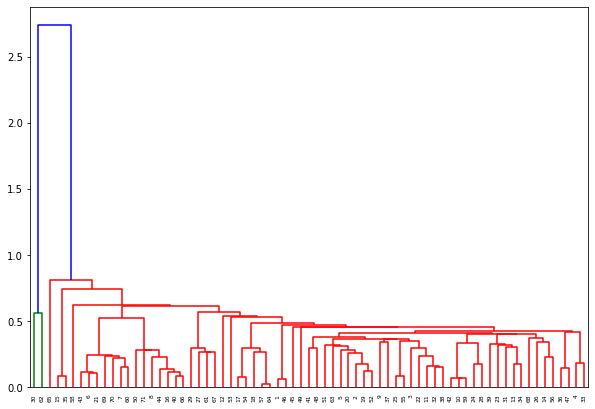

In [77]:
labelList = range(1, 72)
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(log_pd_data, 'single')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [78]:
## by median

linked = linkage(log_pd_data, 'median')


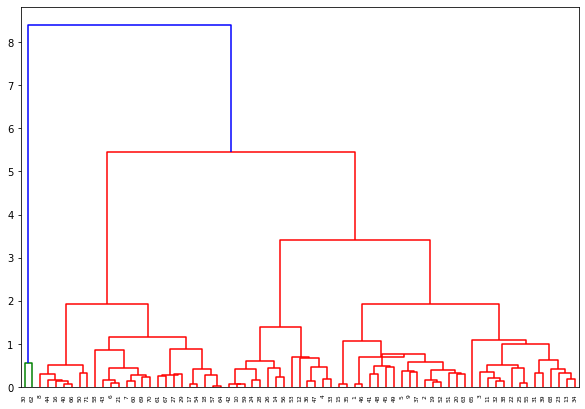

In [79]:
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

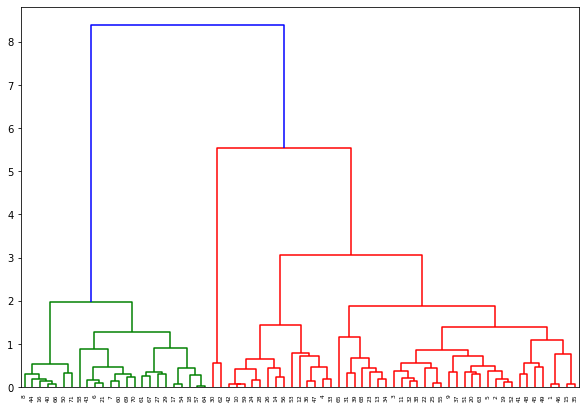

In [89]:
## by weighted averages

linked = linkage(log_pd_data, 'weighted')
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()


In [90]:
from scipy.cluster.hierarchy import fcluster


In [132]:
k=2
l1=pd.DataFrame(fcluster(linked, k, criterion='maxclust'))

In [138]:
l1[0]

0     2
1     2
2     2
3     2
4     2
     ..
66    1
67    2
68    1
69    1
70    1
Name: 0, Length: 71, dtype: int32

In [143]:
level1 = pd.DataFrame({'productcategory': list(df_prd['product_category']),'Level1': l1[0] })

In [144]:
level1_onehot = level1.copy()
level1_onehot = pd.get_dummies(level1_onehot, columns=['Level1'])

print(level1_onehot.head())

              productcategory  Level1_1  Level1_2
0  agro_industry_and_commerce         0         1
1            air_conditioning         0         1
2                         art         0         1
3       arts_and_craftmanship         0         1
4                       audio         0         1


In [146]:
k=3
l2=pd.DataFrame(fcluster(linked, k, criterion='maxclust'))

In [148]:
k=7
l3= pd.DataFrame(fcluster(linked, k, criterion='maxclust'))

In [149]:
k=10
l4= pd.DataFrame(fcluster(linked, k, criterion='maxclust'))

In [150]:
TH = pd.DataFrame({'productcategory': list(df_prd['product_category']),'Level1': l1[0],'Level2': l2[0],'Level3': l3[0],'Level4': l4[0] })

In [152]:
level1_onehot = TH.copy()
level1_onehot = pd.get_dummies(level1_onehot, columns=['Level1','Level2','Level3','Level4'])

print(level1_onehot.head())

              productcategory  Level1_1  Level1_2  Level2_1  Level2_2  \
0  agro_industry_and_commerce         0         1         0         0   
1            air_conditioning         0         1         0         0   
2                         art         0         1         0         0   
3       arts_and_craftmanship         0         1         0         0   
4                       audio         0         1         0         0   

   Level2_3  Level3_1  Level3_2  Level3_3  Level3_4  ...  Level4_1  Level4_2  \
0         1         0         0         0         0  ...         0         0   
1         1         0         0         0         0  ...         0         0   
2         1         0         0         0         0  ...         0         0   
3         1         0         0         0         0  ...         0         0   
4         1         0         0         0         0  ...         0         0   

   Level4_3  Level4_4  Level4_5  Level4_6  Level4_7  Level4_8  Level4_9  \
0    

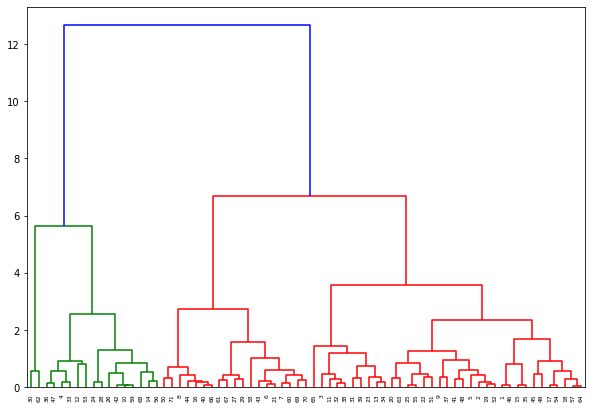

In [82]:
## by median


linked = linkage(log_pd_data, 'complete')
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [87]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster.fit_predict(log_pd_data)

array([1, 1, 3, 0, 1, 2, 2, 2, 1, 0, 3, 0, 3, 0, 1, 2, 1, 1, 1, 1, 2, 3,
       3, 0, 3, 0, 1, 0, 1, 0, 3, 3, 0, 3, 1, 0, 1, 3, 3, 2, 1, 0, 2, 2,
       1, 1, 0, 1, 1, 2, 3, 1, 0, 1, 3, 0, 1, 2, 0, 2, 1, 0, 1, 1, 3, 2,
       1, 0, 2, 2, 2])

In [100]:
matrix = log_data.as_matrix()
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


For n_clusters = 2 The average silhouette_score is : 0.9968140944775328
For n_clusters = 3 The average silhouette_score is : 0.9522818947684449
For n_clusters = 4 The average silhouette_score is : 0.8809163243358028
For n_clusters = 5 The average silhouette_score is : 0.7218982660974869
For n_clusters = 6 The average silhouette_score is : 0.41732517952105114
For n_clusters = 7 The average silhouette_score is : 0.4416217640886696


KeyboardInterrupt: 

In [ ]:
#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')


In [21]:
X_train = [features(row) for _, row in train.iterrows()]

In [22]:
model = LogisticRegression(C = 1.0)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

performance_metrics(y_train, y_train_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[ 2379  8152]
 [ 1792 56762]]


(0.8560613736701165, 0.40234987803279953)

In [23]:
X_valid = [features(row) for _, row in valid.iterrows()]

In [24]:
y_valid_pred = model.predict(X_valid)

performance_metrics(y_valid, y_valid_pred)

[[  890  2674]
 [  621 18843]]


(0.8569133229112385, 0.391092819550485)

In [29]:
model2 = RandomForestClassifier(n_estimators=5)
model2.fit(X_train,y_train)

y_train_pred = model2.predict(X_train)

performance_metrics(y_train, y_train_pred)

[[ 8715  1816]
 [  535 58019]]


(0.9659694579141637, 0.09079006393201916)

In [30]:
y_valid_pred = model2.predict(X_valid)

performance_metrics(y_valid, y_valid_pred)

[[  988  2576]
 [ 1377 18087]]


(0.8283394128886573, 0.3967646910258912)

In [31]:
performance_metrics(y_valid, [1] * len(y_valid))

[[    0  3564]
 [    0 19464]]


(0.8452318916102136, 0.5)

In [12]:
dataset.review_score.value_counts()

5    65799
4    22100
1    13546
3     9706
2     3990
Name: review_score, dtype: int64